In [ ]:
import os
import numpy as np
from google.colab import files
import glob
from pathlib import Path
import cv2

Подключаем google disk

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
root_path = 'gdrive/My Drive/test'

Mounted at /content/gdrive/


Скачивем и распаковываем датасет из задания

In [ ]:
!wget -P /content/gdrive/My\ Drive/test/ -O cats_dogs_dataset.tar https://cloud.neurus.ru/index.php/s/DFQ4jbsoCfLgzXz/download?path=%2F&files=cats_dogs_dataset.tar
!unzip 'cats_dogs_dataset.tar' -d 'gdrive/My Drive/test'

--2021-06-06 09:51:25--  https://cloud.neurus.ru/index.php/s/DFQ4jbsoCfLgzXz/download?path=%2F
Resolving cloud.neurus.ru (cloud.neurus.ru)... 83.69.192.66
Connecting to cloud.neurus.ru (cloud.neurus.ru)|83.69.192.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cats_dogs_dataset.tar’

                        [<=>                 ] 336.01M  16.7MB/s    in 21s     

2021-06-06 09:51:47 (16.1 MB/s) - ‘cats_dogs_dataset.tar’ saved [352337421]

Archive:  cats_dogs_dataset.tar
replace gdrive/My Drive/test/ML/cats_dogs_dataset.tar? [y]es, [n]o, [A]ll, [N]one, [r]ename: 




Скачиваем даркнет сохраняем на google disk

In [ ]:
! git clone  https://github.com/AlexeyAB/darknet /content/gdrive/MyDrive/darknet

Cloning into '/content/gdrive/MyDrive/darknet'...
remote: Enumerating objects: 15069, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15069 (delta 1), reused 8 (delta 0), pack-reused 15056
Receiving objects: 100% (15069/15069), 13.47 MiB | 5.80 MiB/s, done.
Resolving deltas: 100% (10236/10236), done.
Checking out files: 100% (2029/2029), done.


нам нужно загрузить веса предварительно обученной модели, чтобы применить трансферное обучение, а не обучать модель с нуля.

In [ ]:
! wget -P /content/gdrive/MyDrive/darknet https://pjreddie.com/media/files/darknet53.conv.74 

--2021-06-12 08:42:12--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘/content/gdrive/MyDrive/darknet/darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  39.3MB/s    in 4.6s    

2021-06-12 08:42:17 (34.0 MB/s) - ‘/content/gdrive/MyDrive/darknet/darknet53.conv.74’ saved [162482580/162482580]



In [ ]:
#!cp -r darknet/ content/gdrive/MyDrive/darknet

Создаем рабочие директории

In [ ]:
#!mkdir content/gdrive/MyDrive/darknet
!mkdir /content/gdrive/MyDrive/cats_dogs_dataset
!mkdir /content/gdrive/MyDrive/cats_dogs_dataset/train
!mkdir /content/gdrive/MyDrive/cats_dogs_dataset/valid
!mkdir /content/gdrive/MyDrive/darknet/data
!mkdir /content/gdrive/MyDrive/darknet/cfg
!mkdir /content/gdrive/MyDrive/darknet/backup

mkdir: cannot create directory ‘/content/gdrive/MyDrive/cats_dogs_dataset’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/cats_dogs_dataset/train’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/cats_dogs_dataset/valid’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/darknet/data’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/darknet/cfg’: File exists


In [ ]:
 !pip install git+https://github.com/trsvchn/calabar.git

  Cloning https://github.com/trsvchn/calabar.git to /tmp/pip-req-build-49aw394r
  Running command git clone -q https://github.com/trsvchn/calabar.git /tmp/pip-req-build-49aw394r
  Created wheel for calabar: filename=calabar-0.0.1-cp37-none-any.whl size=14703 sha256=e3ae345f6a36f28ed3233df75b01887a94d0f14d7bd9443b5864af9f81f80f99
  Stored in directory: /tmp/pip-ephem-wheel-cache-vk7oz1kk/wheels/ca/da/14/698133dd1400e7c4ef7e108de5b39ec3ba19022b6ef84806f1
Successfully built calabar


In [ ]:
from calabar import untar
#!ls
%cd /content/gdrive/MyDrive/test/ML/
!ls
untar('cats_dogs_dataset.tar','work')

Функция прогресс бара, для отображения поцесса конвертации файлов

In [ ]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

Создаем функцию ковертации файла меток txt, в файл меток формата yolo: 
object-class-id center-x center-y width height и файлы train.txt и valid.txt с ссылками на файлы изображений, также сохраняем изоражения в каталог cat_and_dog_dataset

In [ ]:
def convert_label_YOLO(path_file, path_file_darkn):
    number_of_files = len(glob.glob(path_file + '/*.txt'))
    i = 0
    for name_txt in glob.glob(path_file + '/*.txt'): # перебираем файлы txt в папке указанной в пути
        #print('Цикл')
        i = i+1
        update_progress(i / number_of_files)
        path_name_txt = os.path.basename(name_txt)
        index = path_name_txt.index('.')
        file_name_txt = path_name_txt[:index] #определяем имя файла без пути и расширения
        #print(name_txt)
        for name_jpg in glob.glob(path_file + '/*.jpg'): # перебираем файлы jpg в папке указанной в пути
            path_name_jpg = os.path.basename(name_jpg)
            index = path_name_jpg.index('.')
            file_name_jpg = path_name_jpg[:index]
            #print(file_name_jpg, file_name_txt)
            if file_name_txt == file_name_jpg: # если имя файла jpg соответствует имени фала txt, то
                #print(name_txt, name_jpg)
                f = open(name_txt,'r') # открываем файл txt
                label_file = f.read()
                label_file = label_file.split()
                im = cv2.imread(name_jpg)#открываем картинку
                width = int(im.shape[1]) # ширина изображения
                height = int(im.shape[0]) # высота изображения
                class_id = label_file[0] #извлекаем их файла txt class_id животного, где 1-кошка, 2-собака
                xmin = int(label_file[1]) #извлекаем их файла txt координаты bouding box’а
                ymin = int(label_file[2])
                xmax = int(label_file[3])
                ymax = int(label_file[4])
                w = (xmax - xmin)  / width # ширина bounding box (нормализованое значение)
                h = (ymax - ymin)  / height # высота bounding box (нормализованное значение)
                xc = (xmin + (xmax - xmin) / 2) / width # координаты центра по оси Х bounding box
                yc = (ymin + (ymax - ymin) / 2) / height # координаты центра по оси Y bounding box
                #print('w=', w, 'h=', h, 'xc=',xc,'yc=',yc)
                class_id = int(class_id) - 1 # Приводим значение class_id к формату YOLO,где 0-кошка, 1-собака
                f.close()
                with open(path_file_darkn + '/' + file_name_txt + '.txt', 'w') as f:
                  f.write(str(class_id) + '\n' + str(xc) + '\n' + str(yc) + '\n' + str(w) + '\n' + str(h)) # записываем файл меток в формате yolo <object-class-id> <center-x> <center-y> <width> <height>
                new_picture = im 
                cv2.imwrite(path_file_darkn + '/' + file_name_jpg + '.jpg',  new_picture) #сохраняем изображение в рабочую папку darknet
                index = path_file_darkn.find('train') # проверяем если в пути слово train
                if index > 1:  # если индекс >1 значит слово train в пути есть
                  with open('/content/gdrive/MyDrive/darknet/data/train.txt', 'a') as fp: # записываем в папку data в файл train.txt путь к файлу jpg
                    fp.write(path_file_darkn + '/' + file_name_jpg + '.jpg'+'\n')
                else:
                  with open('/content/gdrive/MyDrive/darknet/data/valid.txt', 'a') as fp: # записываем в папку data в файл valid.txt путь к файлу jpg
                    fp.write(path_file_darkn + '/' + file_name_jpg + '.jpg'+'\n') 
                break    
    update_progress(1)               

In [ ]:
#w = (xmax - xmin) / W # ширина bounding box
#h = (ymax - ymin) / H # высота bounding box
#xc = (xmin + (xmax - xmin) / 2) / W # координаты центра по оси Х bounding box
#yc = (ymin + (ymax - ymin) / 2) / H # координаты центра по оси Y bounding box

In [ ]:
path_train = '/content/gdrive/MyDrive/test/ML/work/cats_dogs_dataset/train'
path_valid = '/content/gdrive/MyDrive/test/ML/work/cats_dogs_dataset/valid'
path_darkn_train = '/content/gdrive/MyDrive/cats_dogs_dataset/train'
path_darkn_valid = '/content/gdrive/MyDrive/cats_dogs_dataset/valid'

In [ ]:
import threading
from datetime import datetime

In [ ]:
path_file = path_train
path_file_darkn = path_darkn_train 
print('Количество файлов в папке ', glob.glob(path_file_darkn), ' = ', len(glob.glob(path_file + '/*.txt')))
#convert_label_YOLO(path_file, path_file_darkn)
t1 = datetime.now() # вычисляем время обработки изображений для папки train
t6 =  datetime.now()
thread_1 = threading.Thread(target=convert_label_YOLO(path_file, path_file_darkn)) # Запускаем многопоточную функцию обработки изображений для папки train
thread_1.start()
path_file = path_valid
path_file_darkn = path_darkn_valid
print('Количество файлов в папке ', glob.glob(path_file_darkn), ' = ', len(glob.glob(path_file + '/*.txt')))
t4 = datetime.now() # вычисляем время обработки изображений для папки valid
t2 = datetime.now()
thread_2 = threading.Thread(target=convert_label_YOLO(path_file, path_file_darkn)) # Запускаем многопоточную функцию обработки изображений для папки valid
thread_2.start()
thread_1.join()
thread_2.join()
t5 = datetime.now()
t7 = datetime.now()
total = t7 - t6 # Общее время на обработку изображений 
total_1 = t2 - t1 # Время на обработку изображений из папки train 
total_2 = t5 - t4 # Время на обработку изображений из папки valid
print('время конвертации из train=',total_1,'время конвертации из valid=', total_2, 'Общее время конвертации', total)

Progress: [####################] 100.0%
время конвертации из train= 0:54:30.265635 время конвертации из valid= 0:06:53.748130 Общее время конвертации 1:01:24.013701


In [ ]:
number_of_elements = 1000
for i in range(number_of_elements):
    time.sleep(0.1) #Replace this with a real computation
    update_progress(i / number_of_elements)

update_progress(1)

Progress: [####################] 100.0%


Добавляем файл cat_dog.names в папку darknet/data/, указываем два класса cat и dog

In [ ]:
with open('/content/gdrive/MyDrive/darknet/data/cat_dog.names', 'w') as f: # записываем в папку data  файл cat_dog.names п
                    f.write('cat'+'\n'+'dog'+'\n')

Добавляем файл cat_dog.data в папку darknet/data/

In [ ]:
with open('/content/gdrive/MyDrive/darknet/data/cat_dog.data', 'w') as f: # записываем в папку data  файл cat_dog.names п
                    f.write('classes = 2'+'\n'+
                            'train = /content/gdrive/MyDrive/darknet/data/train.txt'+'\n'+
                            'valid  = /content/gdrive/MyDrive/darknet/data/valid.txt'+'\n'+
                            'names = /content/gdrive/MyDrive/darknet/data/cat_dog.names'+'\n'+
                            'backup = /content/gdrive/MyDrive/darknet/backup'+'\n')

Копируем файл yolov3.cfg из папки /darknet/cfg в ту же папку с другим названием -cat_dog.cfg

In [ ]:
!cp -a /content/gdrive/MyDrive/darknet/cfg/yolov3.cfg /content/gdrive/MyDrive/darknet/cfg/cat_dog.cfg

Меняем код  как описано ниже:
 
строку №3 batch=1 на batch=64;
 
строку №4 subdivisions=1 на subdivisions=16. В случае проблемы с памятью увеличьте это значение до 32 или 64;
 
входные размеры на заданные(строка № 8, 9): width=192, height=192 (кратно 32); 
 
строку № 20 max_batches = 500200 на max_batches = 4000(#classes * 2000), это даст 4000 итераций для нашей задачи.                                                         
В [yolo] меняем classes=80 на classes = 2 (строка № 610, 696, 783)          
Меняем значение фильтра на filters=(classes + 5) * 3, т.е. filters=21 (строчка № 603, 689, 776)

In [ ]:
%cd /content/gdrive/MyDrive/darknet/cfg
!sed -i 's/batch=1/batch=64/g' cat_dog.cfg
!sed -i 's/subdivisions=1/subdivisions=16/g' cat_dog.cfg
!sed -i 's/height=416/height=192/g' cat_dog.cfg
!sed -i 's/width=416/width=192/g' cat_dog.cfg
!sed -i 's/max_batches = 500200/max_batches = 4000/g' cat_dog.cfg
!sed -i 's/classes=80/classes=2/g' cat_dog.cfg
!sed -i 's/filters=255/filters=21/g' cat_dog.cfg

/content/gdrive/MyDrive/darknet/cfg


In [ ]:
# Edit and start Makefile to include CUDA and cuDNN
%cd /content/gdrive/MyDrive/darknet
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!sed -i "s/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= ${ARCH_VALUE}/g" Makefile
!make

/content/gdrive/MyDrive/darknet
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

In [ ]:
%cd /content/gdrive/MyDrive/darknet
!chmod +x /content/gdrive/MyDrive/darknet
! ./darknet detector train data/cat_dog.data cfg/cat_dog.cfg /content/gdrive/MyDrive/darknet/darknet53.conv.74  -dont_show -i 0 -map -points 1

Выходные данные были обрезаны до нескольких последних строк (5000).
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
 total_bbox = 252828, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.841873), count: 1, class_loss = 0.000131, iou_loss = 0.020566, total_loss = 0.020696 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.895539), count: 1, class_loss = 0.049318, iou_loss = 0.033464, total_loss = 0.082782 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
 total_bbox = 252830, rewritten_bbox = 0.000000 % 

 (next mAP calculation at 3976 iterations) 
 Last accuracy mAP@0.5 = 98.35 %, best = 98.71 % 
 3963: 0.084377, 0.083760 avg loss, 0.001000 rate, 3.064136 s

Проверим нейронную сеть на тестовой выборке на наилучем весе, полученным в результате тестирования (mean_average_precision (mAP@0.5) = 0.974458 )

In [ ]:
%cd /content/gdrive/MyDrive/darknet
!chmod +x /content/gdrive/MyDrive/darknet
!./darknet detector map data/cat_dog.data cfg/cat_dog.cfg /content/gdrive/MyDrive/darknet/backup/cat_dog_best.weights

/content/gdrive/MyDrive/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    192 x 192 x   3 ->  192 x 192 x  32 0.064 BF
   1 conv     64       3 x 3/ 2    192 x 192 x  32 ->   96 x  96 x  64 0.340 BF
   2 conv     32       1 x 1/ 1     96 x  96 x  64 ->   96 x  96 x  32 0.038 BF
   3 conv     64       3 x 3/ 1     96 x  96 x  32 ->   96 x  96 x  64 0.340 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs:  96 x  96 x  64 0.001 BF
   5 conv    128       3 x 3/ 2     96 x  96 x  64 ->   48 x  48 x 128 0.340 BF
   6 conv     64       1 x 1/ 1     48 x  48 x 128 ->   48 x  48 x  64 0.038 BF
   7 conv    128       3 x 3/ 1     48 x  48 x  64 ->   48 x  48 x 128 

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 1.jpg to 1 (2).jpg


In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline
 
  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)
 
  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
 
#imShow('kanadskij_sfinks_04.jpg')

In [ ]:
%cd /content/gdrive/MyDrive/darknet
!chmod +x /content/gdrive/MyDrive/darknet
!./darknet detector demo data/cat_dog.data cfg/cat_dog.cfg backup/cat_dog_best.weights -dont_show 1.jpg -i 0 -out_filename res1.jpg
imShow('/content/gdrive/MyDrive/darknet/data/res1.jpg')

/content/gdrive/MyDrive/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
Demo
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 166, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    192 x 192 x   3 ->  192 x 192 x  32 0.064 BF
   1 conv     64       3 x 3/ 2    192 x 192 x  32 ->   96 x  96 x  64 0.340 BF
   2 conv     32       1 x 1/ 1     96 x  96 x  64 ->   96 x  96 x  32 0.038 BF
   3 conv     64       3 x 3/ 1     96 x  96 x  32 ->   96 x  96 x  64 0.340 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs:  96 x  96 x  64 0.001 BF
   5 conv    128       3 x 3/ 2     96 x  96 x  64 ->   48 x  48 x 128 0.340 BF
   6 conv     64       1 x 1/ 1     48 x  48 x 128 ->   48 x  48 x  64 0.038 BF
   7 conv    128       3 x 3/ 1     48 x  48 x  64 ->   48 x  48 x

AttributeError: ignored

Используем команду для обнаружения обученной сети

In [ ]:
%cd /content/gdrive/MyDrive/darknet
!chmod +x /content/gdrive/MyDrive/darknet
!./darknet detector test data/cat_dog.data cfg/cat_dog.cfg backup/cat_dog_best.weights

/content/gdrive/MyDrive/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 166, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    192 x 192 x   3 ->  192 x 192 x  32 0.064 BF
   1 conv     64       3 x 3/ 2    192 x 192 x  32 ->   96 x  96 x  64 0.340 BF
   2 conv     32       1 x 1/ 1     96 x  96 x  64 ->   96 x  96 x  32 0.038 BF
   3 conv     64       3 x 3/ 1     96 x  96 x  32 ->   96 x  96 x  64 0.340 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs:  96 x  96 x  64 0.001 BF
   5 conv    128       3 x 3/ 2     96 x  96 x  64 ->   48 x  48 x 128 0.340 BF
   6 conv     64       1 x 1/ 1     48 x  48 x 128 ->   48 x  48 x  64 0.038 BF
   7 conv    128       3 x 3/ 1     48 x  48 x  64 ->   48 x  48 x 128 

In [ ]:
%cd /content/gdrive/MyDrive/darknet
!./darknet detector test data/cat_dog.data cfg/cat_dog.cfg backup/cat_dog_best.weights /content/gdrive/MyDrive/darknet/1.jpg

/content/gdrive/MyDrive/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 166, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    192 x 192 x   3 ->  192 x 192 x  32 0.064 BF
   1 conv     64       3 x 3/ 2    192 x 192 x  32 ->   96 x  96 x  64 0.340 BF
   2 conv     32       1 x 1/ 1     96 x  96 x  64 ->   96 x  96 x  32 0.038 BF
   3 conv     64       3 x 3/ 1     96 x  96 x  32 ->   96 x  96 x  64 0.340 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs:  96 x  96 x  64 0.001 BF
   5 conv    128       3 x 3/ 2     96 x  96 x  64 ->   48 x  48 x 128 0.340 BF
   6 conv     64       1 x 1/ 1     48 x  48 x 128 ->   48 x  48 x  64 0.038 BF
   7 conv    128       3 x 3/ 1     48 x  48 x  64 ->   48 x  48 x 128 

Выводим предсказанное изображение с рамкой на просмотр, darknet сохраняет его в файл prediction.jpg

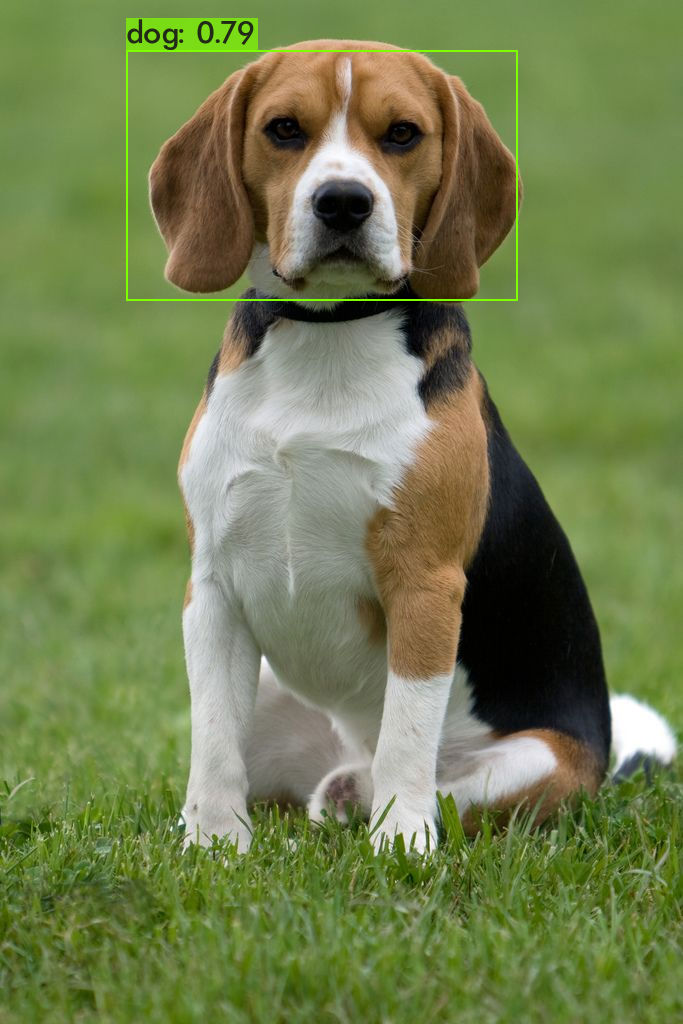

In [ ]:
 from IPython.display import Image
Image('/content/gdrive/MyDrive/darknet/predictions.jpg')

In [ ]:
%cd /content/gdrive/MyDrive/darknet
!./darknet detector test data/cat_dog.data cfg/cat_dog.cfg backup/cat_dog_best.weights /content/gdrive/MyDrive/darknet/1.jpg -ext_output -result.txt

/content/gdrive/MyDrive/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 166, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    192 x 192 x   3 ->  192 x 192 x  32 0.064 BF
   1 conv     64       3 x 3/ 2    192 x 192 x  32 ->   96 x  96 x  64 0.340 BF
   2 conv     32       1 x 1/ 1     96 x  96 x  64 ->   96 x  96 x  32 0.038 BF
   3 conv     64       3 x 3/ 1     96 x  96 x  32 ->   96 x  96 x  64 0.340 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs:  96 x  96 x  64 0.001 BF
   5 conv    128       3 x 3/ 2     96 x  96 x  64 ->   48 x  48 x 128 0.340 BF
   6 conv     64       1 x 1/ 1     48 x  48 x 128 ->   48 x  48 x  64 0.038 BF
   7 conv    128       3 x 3/ 1     48 x  48 x  64 ->   48 x  48 x 128 